In [4]:
# Ячейка 1: Импорты
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Настройка matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [5]:
# Ячейка 2: Загрузка данных
data_path = Path("../data")
low_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_Low_dose.npy")
high_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_High_dose.npy")

print(f"Low dose shape: {low_dose.shape}")
print(f"High dose shape: {high_dose.shape}")
print(f"Low dose dtype: {low_dose.dtype}")
print(f"High dose dtype: {high_dose.dtype}")

# Статистика
print(f"\nLow dose stats:")
print(f"  Min: {low_dose.min():.2f}, Max: {low_dose.max():.2f}")
print(f"  Mean: {low_dose.mean():.2f}, Std: {low_dose.std():.2f}")

print(f"\nHigh dose stats:")
print(f"  Min: {high_dose.min():.2f}, Max: {high_dose.max():.2f}")
print(f"  Mean: {high_dose.mean():.2f}, Std: {high_dose.std():.2f}")

Low dose shape: (256, 256, 48, 48)
High dose shape: (256, 256, 48, 48)
Low dose dtype: float32
High dose dtype: float32

Low dose stats:
  Min: 0.00, Max: 4.08
  Mean: 0.07, Std: 0.20

High dose stats:
  Min: 0.00, Max: 84.14
  Mean: 10.04, Std: 8.99


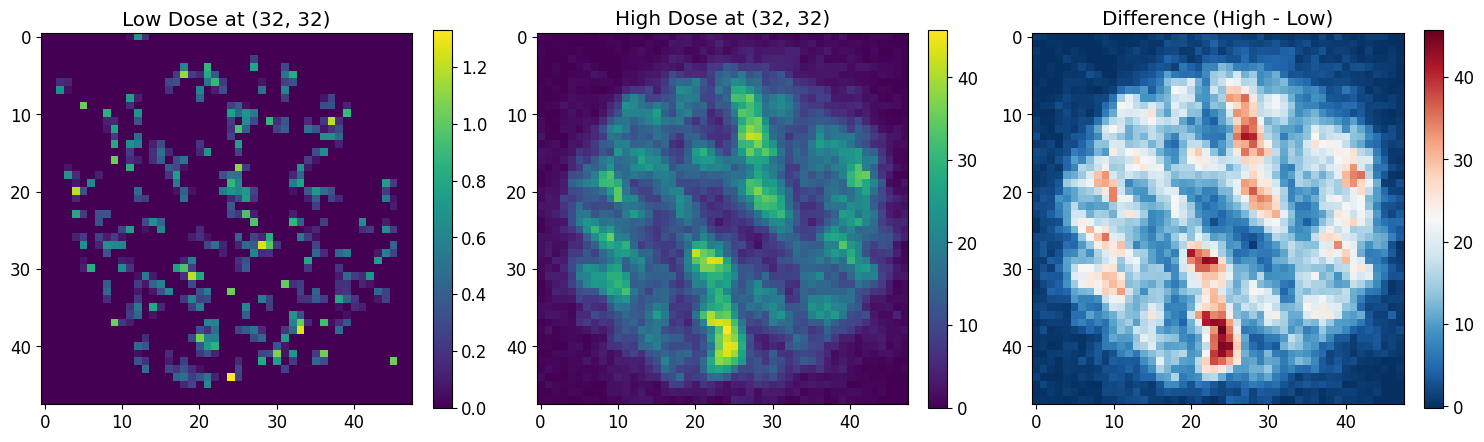

In [6]:
# Ячейка 3: Визуализация CBED паттернов
def plot_cbed_comparison(low, high, position=(32, 32)):
    """Сравнение low и high dose CBED паттернов"""
    x, y = position
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Low dose
    im1 = axes[0].imshow(low[x, y], cmap='viridis', interpolation='nearest')
    axes[0].set_title(f'Low Dose at ({x}, {y})')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # High dose
    im2 = axes[1].imshow(high[x, y], cmap='viridis', interpolation='nearest')
    axes[1].set_title(f'High Dose at ({x}, {y})')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)
    
    # Разница
    diff = high[x, y] - low[x, y]
    im3 = axes[2].imshow(diff, cmap='RdBu_r', interpolation='nearest')
    axes[2].set_title('Difference (High - Low)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046)
    
    plt.tight_layout()
    plt.show()

plot_cbed_comparison(low_dose, high_dose)

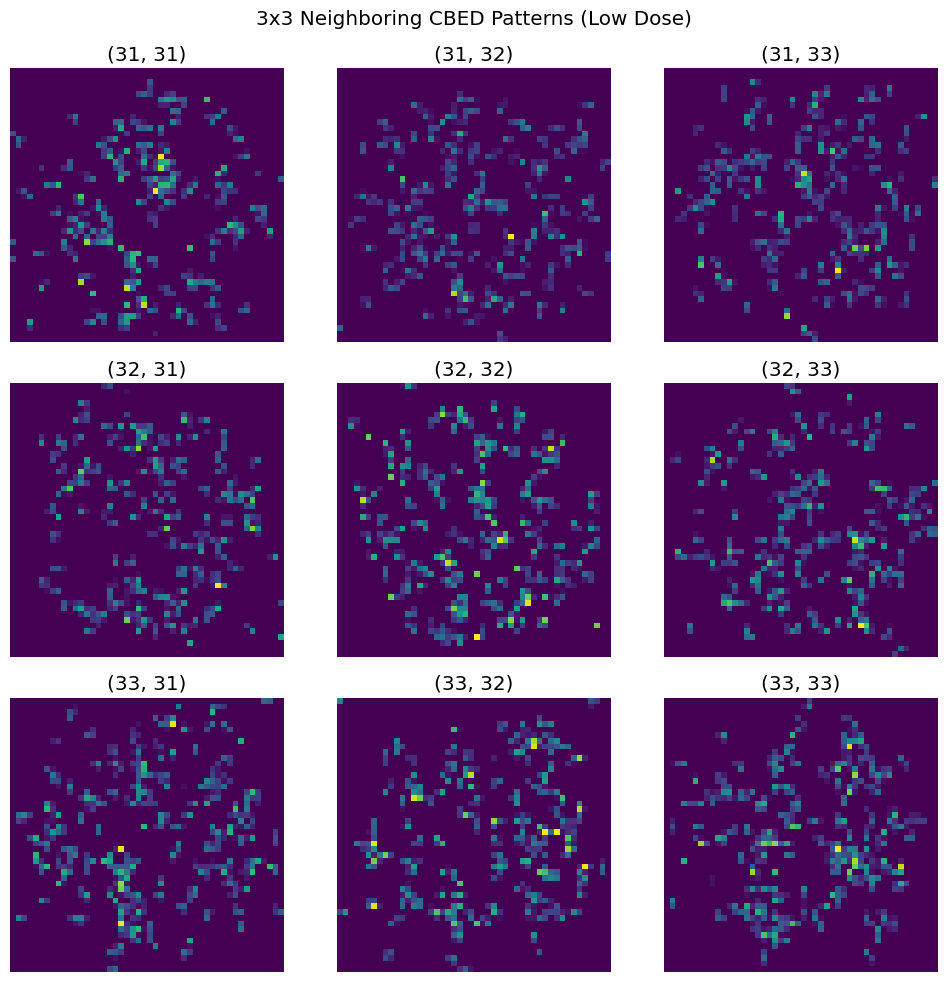

In [7]:
# Ячейка 4: Визуализация соседних паттернов (geometric flow)
def plot_neighboring_patterns(data, center_pos=(32, 32)):
    """Показать 3x3 соседние паттерны"""
    x, y = center_pos
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for i in range(3):
        for j in range(3):
            scan_x = x - 1 + i
            scan_y = y - 1 + j
            
            if 0 <= scan_x < data.shape[0] and 0 <= scan_y < data.shape[1]:
                axes[i, j].imshow(data[scan_x, scan_y], cmap='viridis')
                axes[i, j].set_title(f'({scan_x}, {scan_y})')
            
            axes[i, j].axis('off')
    
    plt.suptitle('3x3 Neighboring CBED Patterns (Low Dose)')
    plt.tight_layout()
    plt.show()

plot_neighboring_patterns(low_dose)

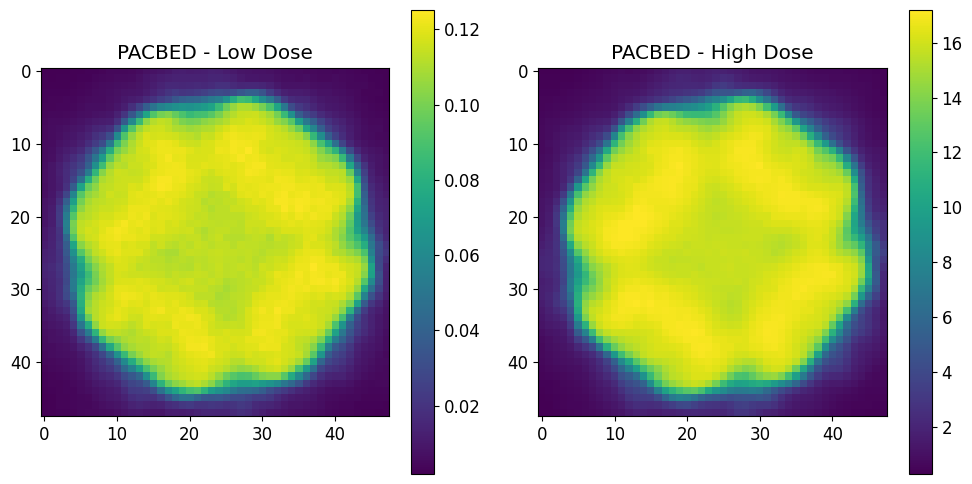

In [8]:
# Ячейка 5: PACBED (Position Averaged CBED)
def calculate_pacbed(data):
    """Вычислить PACBED - усредненный по позициям паттерн"""
    return np.mean(data, axis=(0, 1))

pacbed_low = calculate_pacbed(low_dose)
pacbed_high = calculate_pacbed(high_dose)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(pacbed_low, cmap='viridis')
axes[0].set_title('PACBED - Low Dose')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(pacbed_high, cmap='viridis')
axes[1].set_title('PACBED - High Dose')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


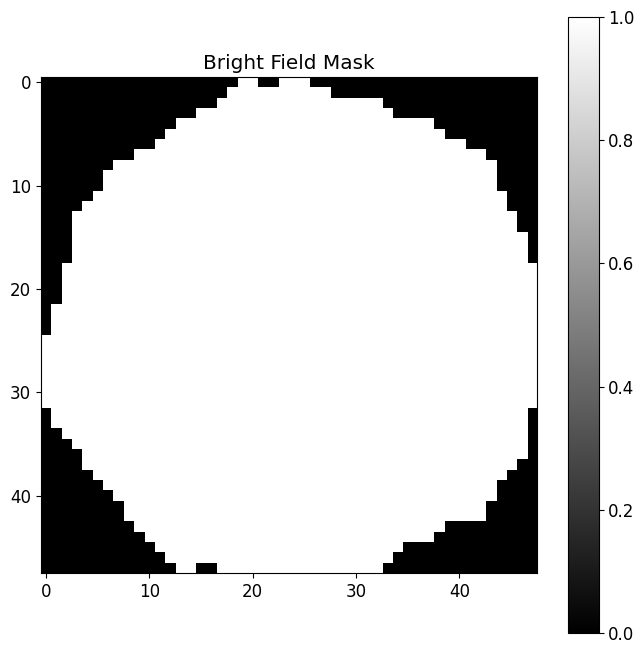

Bright field pixels: 1812
Percentage of total: 78.6%


In [9]:
# Ячейка 6: Определение Bright Field региона
def find_bright_field_mask(pacbed, threshold_factor=0.1):
    """Найти маску bright field диска"""
    threshold = threshold_factor * pacbed.max()
    mask = pacbed > threshold
    return mask

bf_mask = find_bright_field_mask(pacbed_high)

plt.figure(figsize=(8, 8))
plt.imshow(bf_mask, cmap='gray')
plt.title('Bright Field Mask')
plt.colorbar()
plt.show()

print(f"Bright field pixels: {bf_mask.sum()}")
print(f"Percentage of total: {100 * bf_mask.sum() / bf_mask.size:.1f}%")